In [17]:
import os
import sys

from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics, model_selection, preprocessing


import torch
import torch.nn as nn
from torch.nn import functional as F
 
from typing import NamedTuple



sys.path.append('..') 

from utils import cross_validation, test_split, common

plt.rcParams['figure.figsize'] = [12, 8]

In [5]:
def load_dz_data(base_data_dir, target_col="age"):
    """Load the Dzanga Bai data from the Excel spreadsheet into a dataframe.

    Also add the spectrogram path, rumble id, and age category columns.

    Additionally, remove any rumbles that are missing age.
    """
    df = pd.read_excel(
        os.path.join(base_data_dir, 'Age-sex calls- Dzanga Bai.xlsx'),
        sheet_name='context')
    # Create spectrogram paths in the dataframe.
    df['path'] = df['unique_ID'].apply(lambda x: os.path.join(
        base_data_dir, 'spectrograms', f'{x}.png'))
    df['exists'] = df['path'].apply(lambda x: os.path.exists(x))
    df['rumble_id'] = df['unique_ID'].apply(lambda x: int(x.split('_')[1]))
    df_age = df[df[target_col] != 'un']
    df_age['agecat'] = df['age'].apply(
        lambda x: 'ad/sa' if x in ('ad','sa') else 'inf/juv')
    df_age = df_age.reset_index(drop=True)
    return df_age

In [6]:

# Default parameters to use for cross validation splitting if none are
# provided.
_DEFAULT_PARAMS = {
    'BASE_DATA_DIR': 'dzanga-bai-20210816T230919Z-001/dzanga-bai',
    'NUM_K_FOLDS': 5,
    'SEED': 100,
    # Stratify by the 4 category age column to make it more even.
    'STRATIFY_COL': 'age',
    'OUTPUT_PATH': 'dzanga-bai-20210816T230919Z-001/dzanga-bai'
}


class CrossValidator:
    """A class to split a dataset into cross validation folds.
    """

    def __init__(self, params=None):
        """Create a CrossValidator with the given params.
            BASE_DATA_DIR: The path to the directory with the Dzanga Bai data.
            NUM_K_FOLDS: The number of cross validation folds to use.
            SEED: The random seed to use for splitting the train/val data into
                cross validation folds.
            STRATIFY_COL: The column to stratify the data on. The target
                column should be derived from this one.
        """
        self._params = _DEFAULT_PARAMS.copy()
        if params is not None:
            self._params.update(params)


    def get_no_leakage_crossval_splits(self, train_val_indices):
        """Split the Dzanga Bai data into cross validation folds.

        Stratify by STRATIFY_COL and ensure no data leaks by adding rumbles
        with the same id to the same split.

        Output the indices as separate train and validation csvs for each
        fold.
        """
        df = common.load_dz_data(self._params['BASE_DATA_DIR'], target_col = self._params['STRATIFY_COL'])
        num_folds = self._params['NUM_K_FOLDS']
        train_val_df = df.iloc[train_val_indices]

        # Split the train/val set into NUM_K_FOLDS different folds with a seed
        # that can change between runs to get different cross validation
        # splits for different trials.
        stratify_col = self._params['STRATIFY_COL']
        split_sizes = [len(train_val_indices) / num_folds] * num_folds
        split_indices = common.split_and_stratify_without_leakage(
            train_val_df, self._params['SEED'], split_sizes, stratify_col)
        # Test indices are assumed to be all other indices.
        test_indices = set(range(len(df))) - set(train_val_indices)
        for i in range(len(split_indices)):
            # Train is all splits except the current split.
            # Validation is the current split.
            # These indices are relative to the train_val_df.
            # They are later converted to be of the original df.
            train_indices_old = np.concatenate(
                split_indices[:i] + split_indices[i+1:]).ravel()
            val_indices_old = split_indices[i]
            #train_indices_old = [j for j in split_indices if j not in val_indices_old]
            # Get the iloc indices for train and val in the original df.
            train_idx_original_indices = set(
                train_val_df.iloc[train_indices_old].index.values)
            val_idx_original_indices = set(
                train_val_df.iloc[val_indices_old].index.values)
            train_idx = df.reset_index()[df.reset_index()['index'].apply(
                lambda x: x in train_idx_original_indices)].index
            val_idx = df.reset_index()[df.reset_index()['index'].apply(
                lambda x: x in val_idx_original_indices)].index
            # For each fold, there should be no overlap between train, val,
            # and test.
            assert(len(set(train_idx) | set(val_idx) | test_indices)
                == len(train_idx) + len(val_idx) + len(test_indices))
            train_indices_filename = os.path.join(
                self._params['OUTPUT_PATH'], f'train_indices_{i}.csv')
            val_indices_filename = os.path.join(
                self._params['OUTPUT_PATH'], f'val_indices_{i}.csv')
            common.output_csv(train_indices_filename, train_idx)
            common.output_csv(val_indices_filename, val_idx)



In [7]:


# Seed for splitting the dataset into train/val and test. It should be
# hardcoded to ensure the test set is always the same.
_DEFAULT_SEED_FOR_TRAIN_TEST_SPLIT = 22


# Default parameters to use for test splitting if none are provided.
_DEFAULT_PARAMS = {
    'BASE_DATA_DIR': 'dzanga-bai-20210816T230919Z-001/dzanga-bai',
    # Stratify by the 4 category age column to make it more even.
    'STRATIFY_COL': 'age',
    'TEST_SIZE': 0.2,
    'OUTPUT_PATH': 'dzanga-bai-20210816T230919Z-001/dzanga-bai'
}


class TestSplitter:
    """A class to split a dataset into cross validation folds and a test set.
    """

    def __init__(self, params=None):
        """Create a TestSplitter with the given params.
            BASE_DATA_DIR: The path to the directory with the Dzanga Bai data.
            STRATIFY_COL: The column to stratify the data on. The target
                column should be derived from this one.
            TEST_SIZE: The fraction of data to use for testing.
        """
        self._params = _DEFAULT_PARAMS.copy()
        if params is not None:
            self._params.update(params)

    def get_no_leakage_trainval_test_splits(self):
        """Split the Dzanga Bai data into training/validation and a test set.

        Stratify by STRATIFY_COL and ensure no data leaks by adding rumbles
        with the same id to the same split.

        Output the indices as separate csvs for training/validation and test.
        """
        df = common.load_dz_data(self._params['BASE_DATA_DIR'], target_col = _params['STRATIFY_COL'])
        stratify_col = self._params['STRATIFY_COL']
        test_size = self._params['TEST_SIZE']
        seed = _DEFAULT_SEED_FOR_TRAIN_TEST_SPLIT
        split_sizes = [1 - test_size, test_size]
        train_val_indices, test_indices = (
            common.split_and_stratify_without_leakage(
                df, seed, split_sizes, stratify_col))
        train_val_indices_filename = os.path.join(
            self._params['OUTPUT_PATH'], 'train_val_indices.csv')
        test_indices_filename = os.path.join(
            self._params['OUTPUT_PATH'], 'test_indices.csv')
        common.output_csv(train_val_indices_filename, train_val_indices)
        common.output_csv(test_indices_filename, test_indices)


In [8]:
PARAMS = {
    'NUM_K_FOLDS': 5,
    'BASE_DATA_DIR': '../data/metadata',
    'OUTPUT_PATH': '../data/metadata',
    'SPECTROGRAM_DIR' :  "../data/metadata/spectrograms",
    "STRATIFY_COL" : "agecat",
    'SEED': 200  # Only used for cross-validation
}
 

In [9]:
df = common.load_dz_data(PARAMS['BASE_DATA_DIR']) 
df.head()

,unique_ID,call_type,comb,in_analysis,final_cat,final_subcat,distress,age,sex,agsex,path,exists,rumble_id,agecat
0,opp_330_ru,ru,n,y,nrs,nrs,na,juv,un,un,../data/metadata/spectrograms/opp_330_ru.png,True,330,inf/juv
1,opp_332_ru,ru,n,y,logistics,leave,na,ad,f,adf,../data/metadata/spectrograms/opp_332_ru.png,True,332,ad/sa
2,opp_333_ru,ru,n,y,unspecific,unspecific,na,ad,f,adf,../data/metadata/spectrograms/opp_333_ru.png,True,333,ad/sa
3,opp_333_ru1,ru,n,y,unspecific,unspecific,na,ad,f,adf,../data/metadata/spectrograms/opp_333_ru1.png,True,333,ad/sa
4,opp_333_ru2,ru,n,y,unspecific,unspecific,na,ad,f,adf,../data/metadata/spectrograms/opp_333_ru2.png,True,333,ad/sa


In [10]:
# Creating Train/Test splits
train_val_indices, test_indices =test_split.TestSplitter(PARAMS).get_no_leakage_trainval_test_splits()
train_val_indices, test_indices

(array([139,  87, 279, 325, 326, 320,  30,  31, 165, 166, 167, 273, 175,
        176, 177, 178, 179, 180, 258, 259, 260, 283, 284, 285, 131, 132,
        133,  51,  52,  54, 150, 212, 300, 233, 335, 198,  85, 151, 246,
        247,  90,  91,  92, 261, 262, 263, 264, 265, 228, 302,   5, 215,
        236, 237,  96,  97,  98,  99, 100, 101, 299, 346, 211, 314, 315,
        221, 222, 135, 136, 137,  46,  18,  19, 155, 156, 157, 158, 159,
        160, 161,  67, 305, 306, 307, 308, 309, 217, 218, 219,  68,  69,
         70, 296, 128,  86,  28, 274, 352, 353, 318, 319, 282,  20, 134,
          8,  53, 257, 195, 196,  41,  72,  73,  74, 191, 192, 129, 130,
        145, 272,  16,  40, 121, 244, 154,   1,  66,  34,  35, 200, 280,
        286, 122,  15, 119, 206,  57,  58,  59,  60, 336, 171, 172, 169,
        170, 104, 105,  17, 251, 252, 275, 256, 138,  93,  94,  95,  71,
        340, 341,  63, 327, 328, 209, 290, 321,  25, 288, 266, 267, 323,
        281, 123,   6,  32,  33,  55, 253, 294, 295

In [11]:
train_df = df[df.index.isin(train_val_indices)]
test_df = df[df.index.isin(test_indices)]
len(train_df), len(test_df)

(255, 66)

(array([ 76.,   0.,   0., 101.,   0.,   0.,  72.,   0.,   0.,   6.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

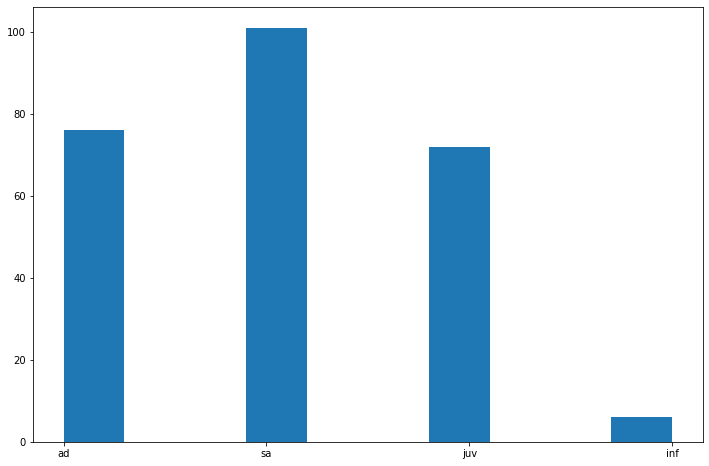

In [12]:
plt.hist(train_df.age)

In [13]:
def get_train_val_indices(PARAMS):
    train_val_indices_filename = os.path.join(
        PARAMS['OUTPUT_PATH'], 'train_val_indices.csv')
    with open(train_val_indices_filename, 'rt') as f:
        train_val_indices = np.array([int(index) for index in f.readlines()])
    return train_val_indices

def get_test_indices(PARAMS):
    test_indices_filename = os.path.join(
        PARAMS['OUTPUT_PATH'], 'test_indices.csv')
    with open(test_indices_filename, 'rt') as f:
        test_indices = np.array([int(index) for index in f.readlines()])
    return test_indices

train_val_indices = get_train_val_indices(PARAMS)
cross_validation.CrossValidator(PARAMS).get_no_leakage_crossval_splits(train_val_indices)

In [14]:
def fold_gen(df,nfolds = PARAMS["NUM_K_FOLDS"], base_dir = PARAMS["BASE_DATA_DIR"], output_path=PARAMS["OUTPUT_PATH"]):
    for fold in range(nfolds):
        with open(os.path.join(output_path,f"train_indices_{fold}.csv"),"rt") as f:
            train_indices = np.array([int(index) for index in f.readlines()])
        with open(os.path.join(output_path,f"val_indices_{fold}.csv"),"rt") as f:
            val_indices = np.array([int(index) for index in f.readlines()])

        train_df = df[df.index.isin(train_indices)].reset_index(drop=True)
        val_df = df[df.index.isin(val_indices)].reset_index(drop=True)
        yield train_df, val_df

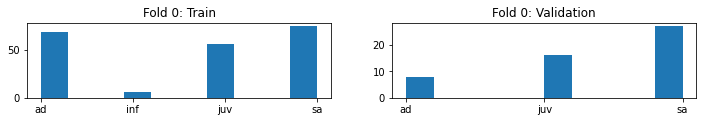

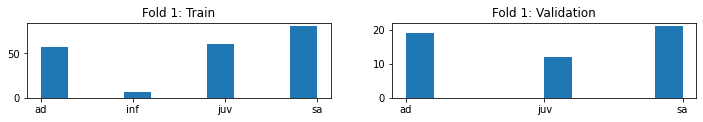

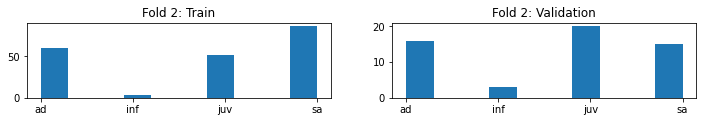

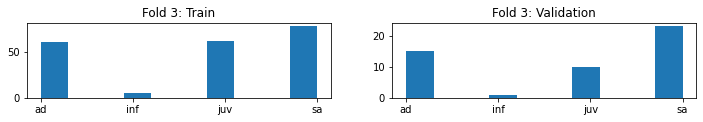

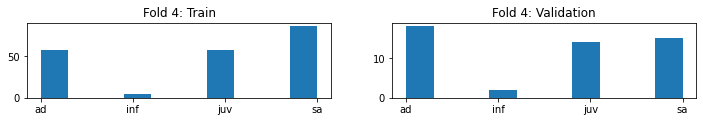

In [15]:
# Checking distribution of folds
for i,(train_df, val_df) in enumerate(fold_gen(df)):
    plt.subplot(5, 2, 1)
    plt.title(f"Fold {i}: Train")
    plt.hist(sorted(train_df["age"]))

    plt.subplot(5, 2, 2)    
    plt.title(f"Fold {i}: Validation")
    plt.hist(sorted(val_df["age"]))
    plt.show()

Some folds appear to be missing infants from the age groups. This can cause issues for the validation score that will be exacerbated once we use upsampling

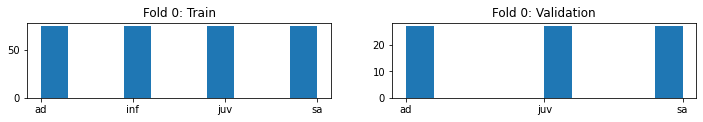

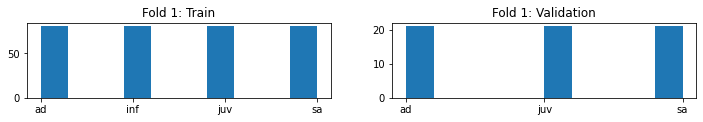

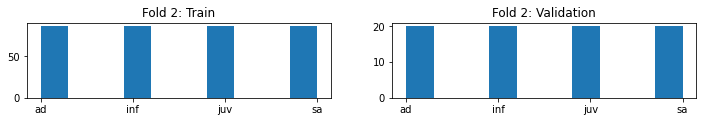

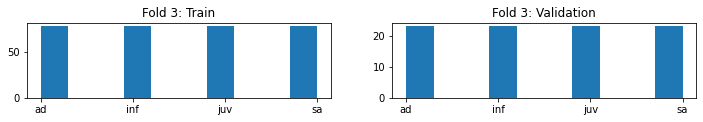

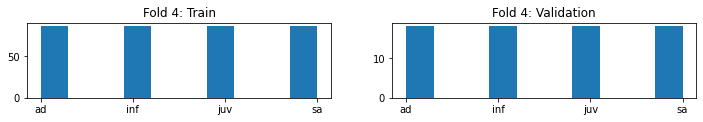

In [20]:

def up_sample(df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    """ Sample dataframe records with replacement to match max group size"""
    max_class_size = int(df[target_col].value_counts().max())
    balanced = pd.concat(
        [
            group.sample(max_class_size, replace=True)
            if len(group) < max_class_size
            else group
            for _, group in df.groupby(target_col)
        ]
    )

    return balanced


# Checking distribution of folds
for i,(train_df, val_df) in enumerate(fold_gen(df)):
    plt.subplot(5, 2, 1)
    plt.title(f"Fold {i}: Train")
    train_df = up_sample(train_df, "age")
    plt.hist(sorted(train_df["age"]))

    plt.subplot(5, 2, 2)    
    plt.title(f"Fold {i}: Validation")
    val_df = up_sample(val_df, "age")
    plt.hist(sorted(val_df["age"]))
    plt.show()

We consistently seem to have a few folds with no infant records.

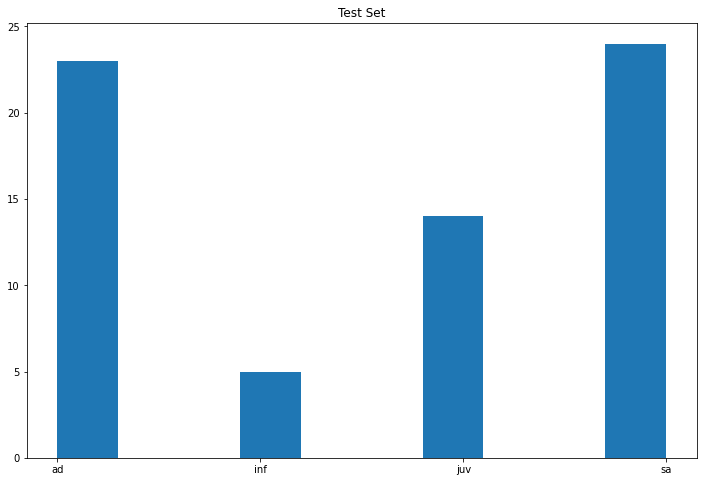

In [15]:
# Check test set distribution
test_df = df[df.index.isin(get_test_indices(PARAMS))]
plt.title("Test Set")
plt.hist(sorted(test_df["age"]))
plt.show()

In [24]:
#Add wav paths
df["wav_path"] = "../data/raw/" + df["unique_ID"] + ".wav"

In [25]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil:

    # Load an audio file. Much quicker than using librosa
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)

    # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr // 1000 * max_ms

        if sig_len > max_len:
            # Truncate the signal to the given length
            sig = sig[:, :max_len]

        elif sig_len < max_len:
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)

        return (sig, sr)

    # ----------------------------
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    # ----------------------------
    @staticmethod
    def time_shift(aud, shift_limit):
        sig, sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig, sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(
            sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels
        )(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return spec

    # ----------------------------
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    # ----------------------------
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(
                aug_spec, mask_value
            )

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec


In [27]:
import librosa
sigs = []
srs = []
for f in df.wav_path:
    sig, sr = librosa.load(f)
    sigs.append(sig)
    srs.append(sr)

Lets take a look at the distribution of the lengths of our wavs. The max duration will be used for data augmentation

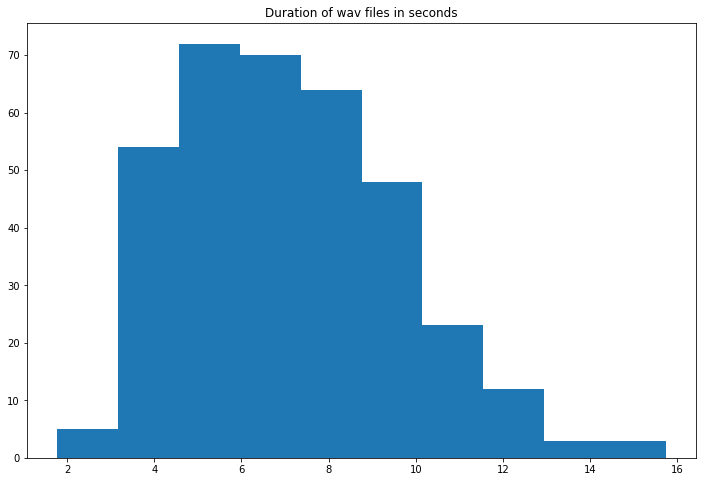

In [28]:
plt.hist(([librosa.get_duration(y=sigs[i], sr=srs[i]) for i in range(len(sigs))]))
plt.title("Duration of wav files in seconds")
plt.show()

In [29]:
set(srs)

{22050}

All wav files are of the same sampling rate, so no data augmentation required here. When working with new wav files, we may need to adjust the sampling rate

In [30]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

Plotting a wav from pytorch

In [40]:
i = 1

import IPython.display as ipd
ipd.Audio(df.wav_path[i]) # load a local WAV file



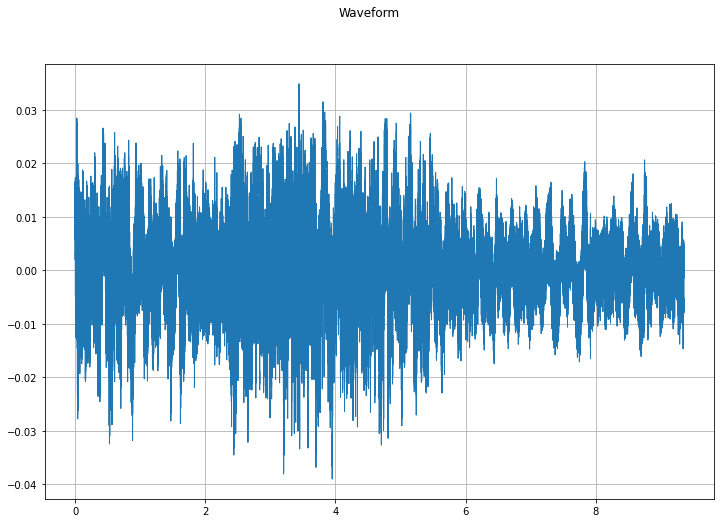

In [41]:
w,s = AudioUtil.open(df.wav_path[i])
plot_waveform(w,s)

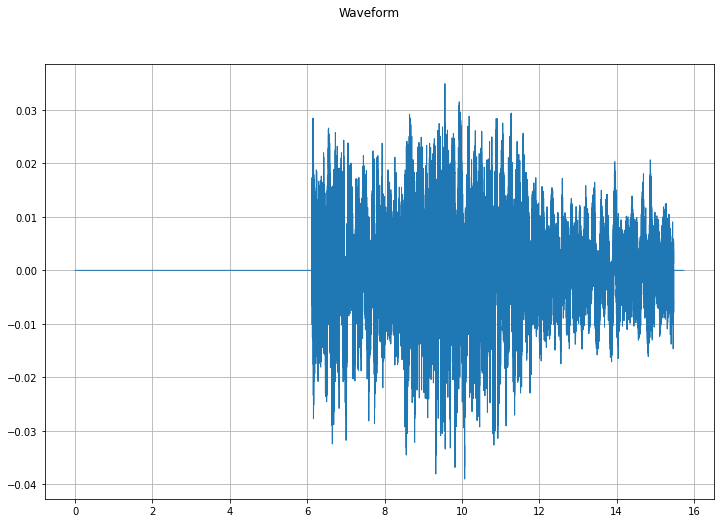

In [42]:
w,s = AudioUtil.pad_trunc((w,s), 15739) # max duration of wav
plot_waveform(w,s)


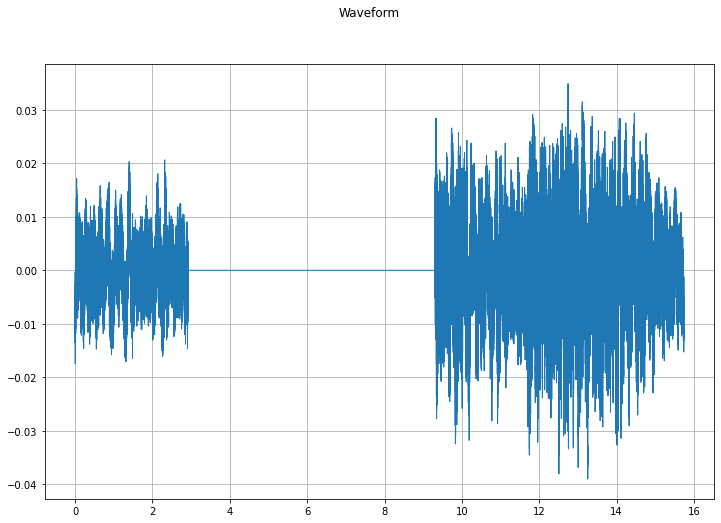

In [43]:
w, s=AudioUtil.time_shift((w,s), 0.4)
plot_waveform(w,s)

In [45]:
spec= AudioUtil.spectro_gram((w,s), n_mels=100, n_fft=1024, hop_len=None)

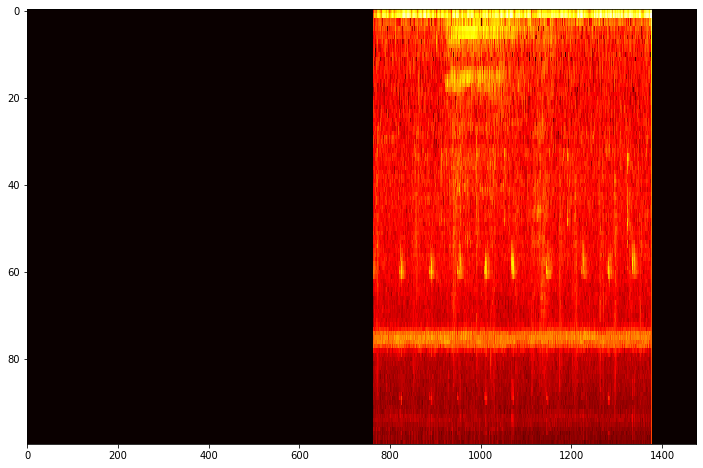

In [131]:

plt.rcParams['figure.figsize'] = [12, 8]
plt.imshow( spec.permute(1, 2, 0)  , interpolation='nearest', aspect='auto', cmap="hot")


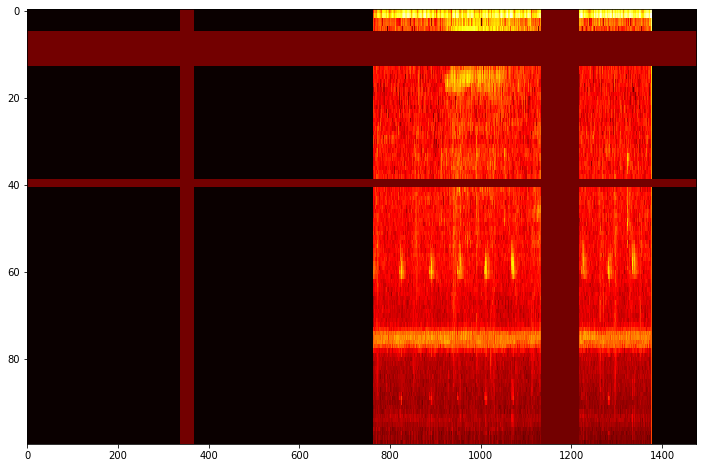

In [130]:
h = AudioUtil.spectro_augment(s, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
plt.imshow( h.permute(1, 2, 0)  , interpolation='nearest', aspect='auto', cmap="hot")